In [2]:
# general libraries
import os
import sys
import math
import statistics
import collections
import missingno as msno
from pylab import MaxNLocator
from collections import defaultdict
import seaborn as sns
import ast
from pathlib import Path
# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal
import IPython.display as ipd

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# scipy libraries
from scipy.stats import pearsonr

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

In [3]:
sns.set()

In [4]:
tracks = pd.read_csv(r'C:\Users\jigok\OneDrive\Desktop\UniPISA\2semestre2Anno\DataMining2\Progetto\Data\fma_metadata\tracks.csv',low_memory=False,index_col=0, header=[0, 1])

COLUMNS = [('track', 'tags'), ('album', 'tags'),('artist', 'tags'),
           ('track', 'genres'), ('track', 'genres_all')]

for column in COLUMNS:
     tracks[column] = tracks[column].map(ast.literal_eval)
        
COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
           ('album', 'date_created'), ('album', 'date_released'),
           ('artist', 'date_created'), ('artist', 'active_year_begin'),
           ('artist', 'active_year_end')]
for column in COLUMNS:
     tracks[column] = pd.to_datetime(tracks[column])
        
COLUMNS = [('track', 'genre_top'), ('track', 'license'),
           ('album', 'type'), ('album', 'information'),
           ('artist', 'bio')]
for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')


In [5]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 52 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   (album, comments)            106574 non-null  int64         
 1   (album, date_created)        103045 non-null  datetime64[ns]
 2   (album, date_released)       70294 non-null   datetime64[ns]
 3   (album, engineer)            15295 non-null   object        
 4   (album, favorites)           106574 non-null  int64         
 5   (album, id)                  106574 non-null  int64         
 6   (album, information)         83149 non-null   category      
 7   (album, listens)             106574 non-null  int64         
 8   (album, producer)            18060 non-null   object        
 9   (album, tags)                106574 non-null  object        
 10  (album, title)               105549 non-null  object        
 11  (album, tracks)           

In [96]:
ipd.display(tracks['track'].head(10))
ipd.display(tracks['album'].head(10))
ipd.display(tracks['artist'].head(10))
ipd.display(tracks['set'].head(10))

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level
26,256000,0,NaN,2008-11-26 01:49:05,2008-01-01,181,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,1060,en,Attribution-NonCommercial-NoDerivatives (aka M...,193,NaN,4,NaN,[],Where is your Love?
30,256000,0,NaN,2008-11-26 01:49:11,2008-01-01,174,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,718,en,Attribution-NonCommercial-NoDerivatives (aka M...,612,NaN,5,NaN,[],Too Happy
46,256000,0,NaN,2008-11-26 01:49:53,2008-01-01,104,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,252,en,Attribution-NonCommercial-NoDerivatives (aka M...,171,NaN,8,NaN,[],Yosemite
48,256000,0,NaN,2008-11-26 01:49:56,2008-01-01,205,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,247,en,Attribution-NonCommercial-NoDerivatives (aka M...,173,NaN,9,NaN,[],Light of Light


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album
26,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album
30,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album
46,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album
48,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN
26,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN
30,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN
46,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN
48,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large
26,training,large
30,training,large
46,training,large
48,training,large


In [7]:
top_data = msno.nullity_filter(tracks, filter='bottom', n= 50)

# Looking the single column value

In [8]:
tracks[("album", "tags")]

track_id
2                                                        []
3                                                        []
5                                                        []
10                                                       []
20                                                       []
                                ...                        
155316                                                   []
155317                                                   []
155318                                                   []
155319                                                   []
155320    [ballad, epic, rockabilly, curse, hex, hard ro...
Name: (album, tags), Length: 106574, dtype: object

In [9]:
tracks[("album", "favorites")]

track_id
2         4
3         4
5         4
10        4
20        2
         ..
155316    0
155317    0
155318    0
155319    0
155320    1
Name: (album, favorites), Length: 106574, dtype: int64

(array([1.00929e+05, 4.25800e+03, 7.36000e+02, 2.81000e+02, 1.73000e+02,
        6.30000e+01, 4.90000e+01, 2.10000e+01, 7.00000e+00, 5.70000e+01]),
 array([-1. ,  5.2, 11.4, 17.6, 23.8, 30. , 36.2, 42.4, 48.6, 54.8, 61. ]),
 <a list of 10 Patch objects>)

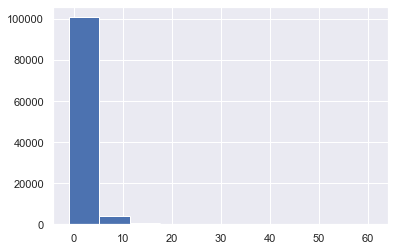

In [10]:
plt.hist(tracks[("album", "favorites")])

In [81]:
tracks[("album", "favorites")].value_counts()

 0     53679
 1     23757
 2     10349
 3      5366
-1      3529
 4      2542
 5      1707
 6      1330
 7       942
 8       898
 10      422
 11      373
 12      297
 9       293
 14      159
 13       99
 23       75
 16       74
 19       71
 25       69
 17       66
 18       58
 31       49
 15       41
 55       38
 24       31
 22       29
 20       28
 29       26
 21       20
 28       20
 39       18
 26       15
 40       15
 47       14
 27       12
 61       10
 38       10
 33        9
 60        9
 43        7
 54        7
 37        6
 36        5
Name: (album, favorites), dtype: int64

In [25]:
tracks[("track", "favorites")]

track_id
2           2
3           1
5           6
10        178
20          0
         ... 
155316      1
155317      1
155318      2
155319      0
155320      1
Name: (track, favorites), Length: 106574, dtype: int64

Text(0, 0.5, 'count')

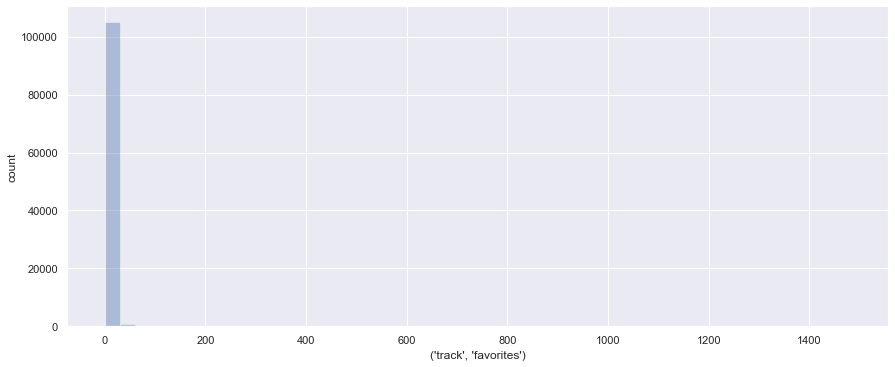

In [47]:
fig =plt.subplots(figsize=(50, 20))
ax = plt.subplot2grid(fig_dims, (0, 0))
sns.distplot(tracks[("track", "favorites")].dropna(), kde=False)
plt.ylabel("count")


In [83]:
tracks[("track", "favorites")].value_counts()

0      41979
1      23666
2      12488
3       7324
4       4631
       ...  
161        1
288        1
479        1
221        1
157        1
Name: (track, favorites), Length: 243, dtype: int64

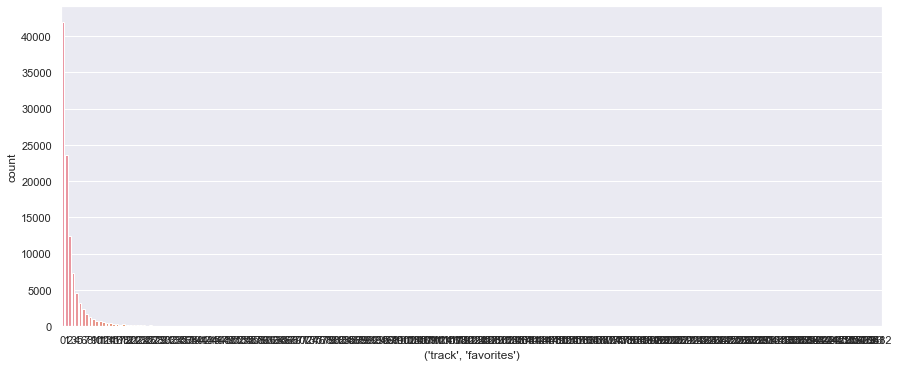

In [49]:
fig =plt.subplots(figsize=(50, 20))
ax = plt.subplot2grid(fig_dims, (0, 0))
sns.countplot(x=('track','favorites'), data=tracks)

In [11]:
tracks[("track", "genre_top")]

track_id
2         Hip-Hop
3         Hip-Hop
5         Hip-Hop
10            Pop
20            NaN
           ...   
155316       Rock
155317       Rock
155318       Rock
155319       Rock
155320        NaN
Name: (track, genre_top), Length: 106574, dtype: category
Categories (16, object): [Blues, Classical, Country, Easy Listening, ..., Pop, Rock, Soul-RnB, Spoken]

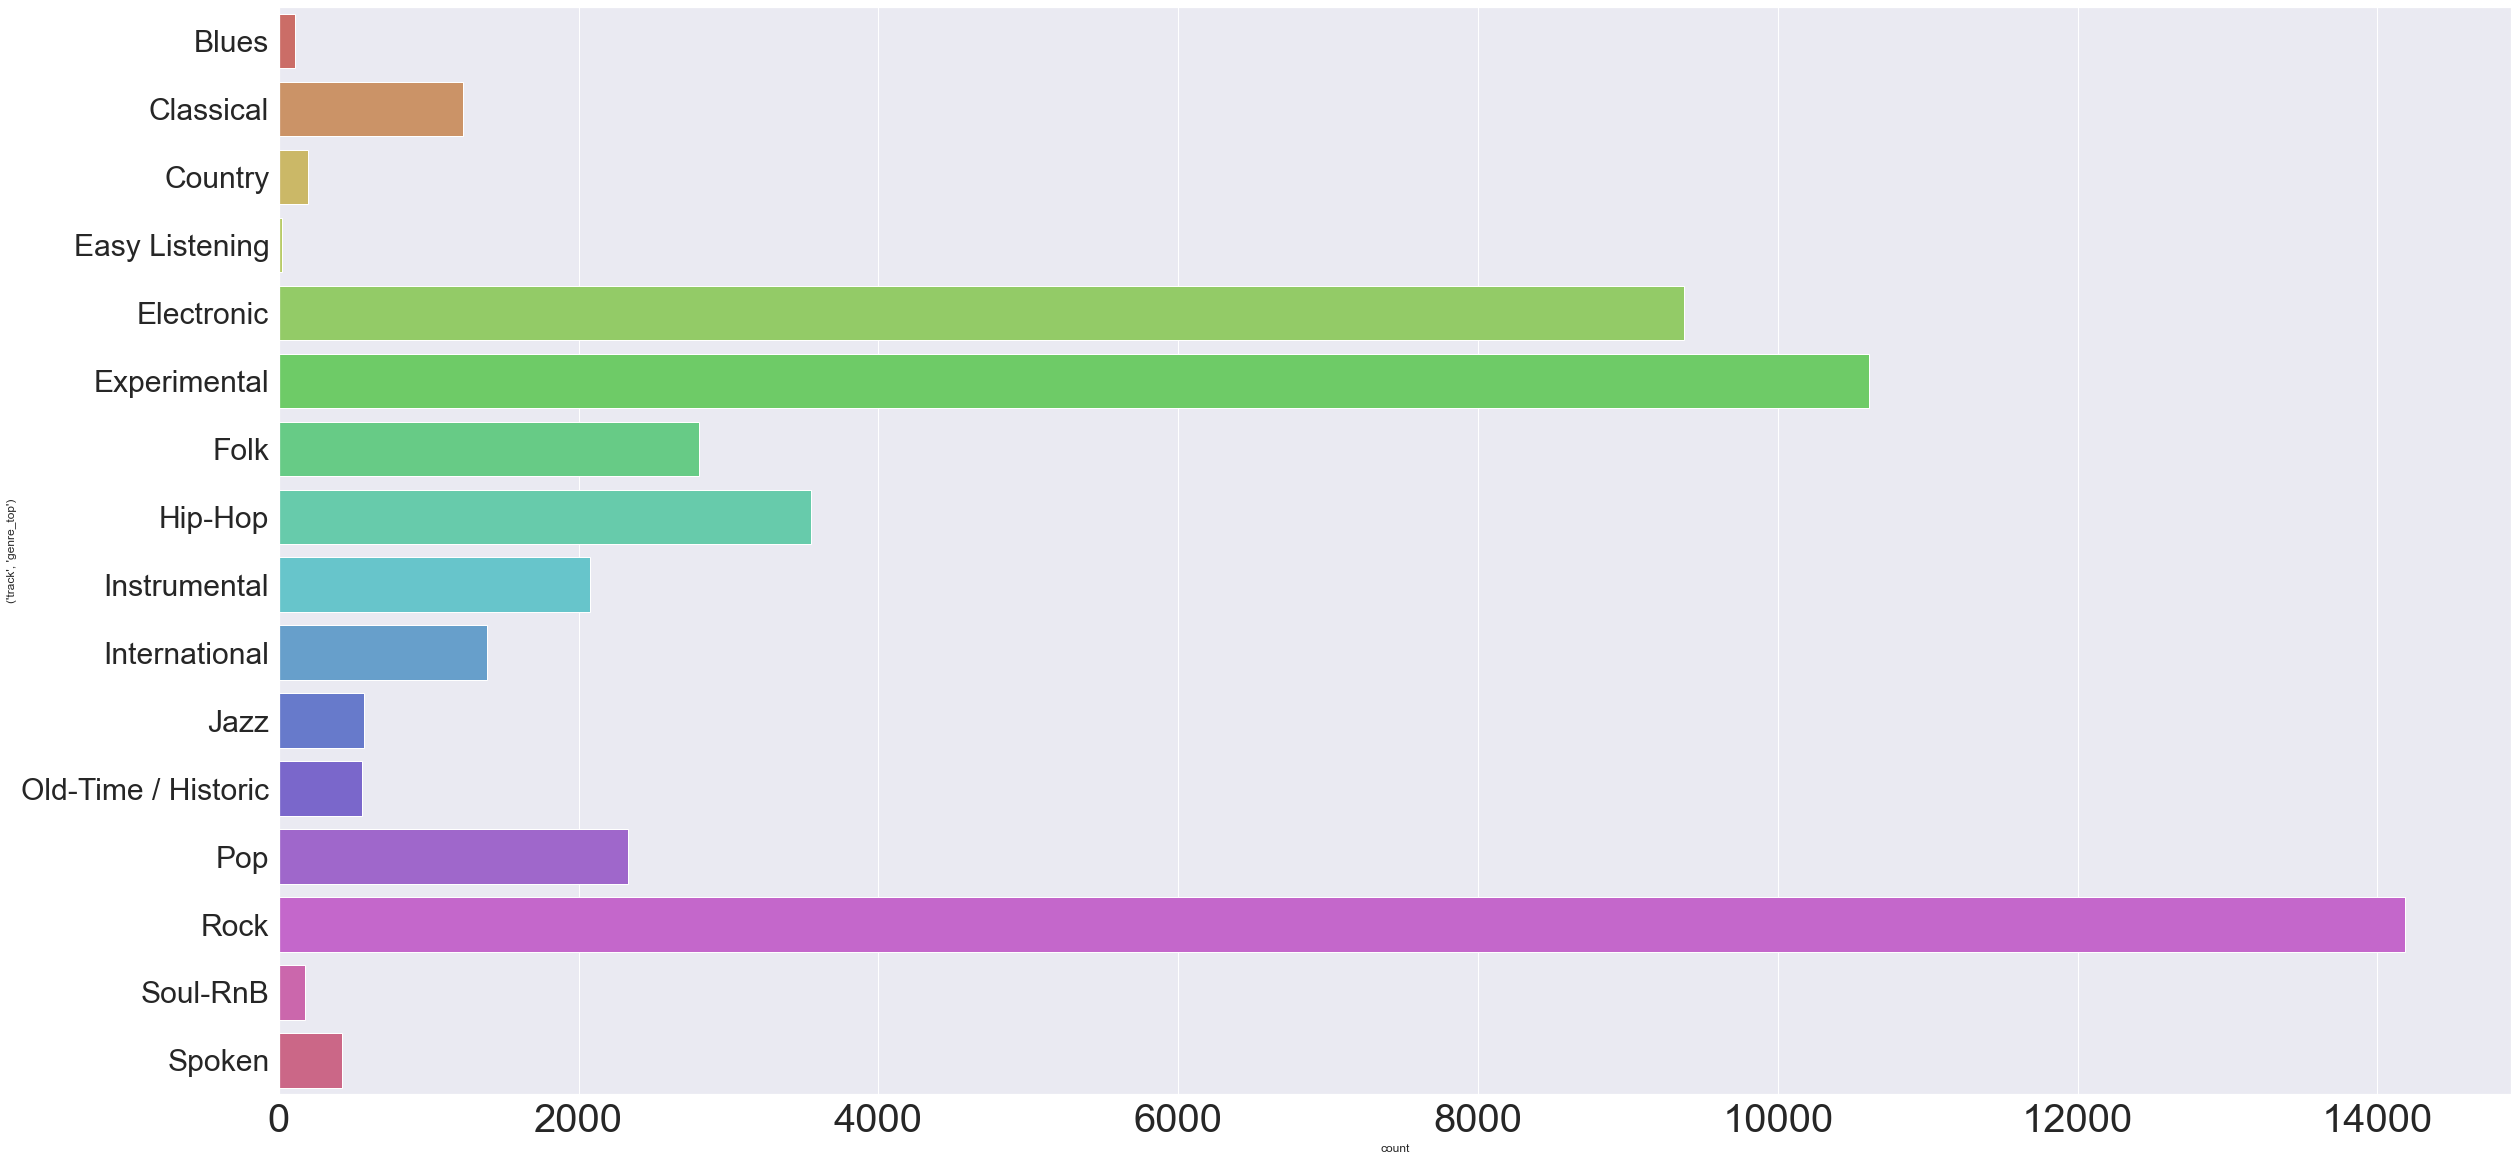

In [73]:
fig =plt.subplots(figsize=(40, 20))
ax = sns.countplot(y=("track", "genre_top"), data=tracks, palette='hls')
plt.yticks(fontsize=30)
plt.xticks(fontsize=40)
plt.show()

In [85]:
tracks[("track", "genre_top")].value_counts()

Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3552
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: (track, genre_top), dtype: int64

In [13]:
tracks[("album","id")]

track_id
2             1
3             1
5             1
10            6
20            4
          ...  
155316    22940
155317    22940
155318    22940
155319    22940
155320    22906
Name: (album, id), Length: 106574, dtype: int64

(array([ 5990.,  7796.,  8691., 10302., 10802., 11245., 12403., 14088.,
        12799., 12458.]),
 array([-1.00000e+00,  2.29310e+03,  4.58720e+03,  6.88130e+03,
         9.17540e+03,  1.14695e+04,  1.37636e+04,  1.60577e+04,
         1.83518e+04,  2.06459e+04,  2.29400e+04]),
 <a list of 10 Patch objects>)

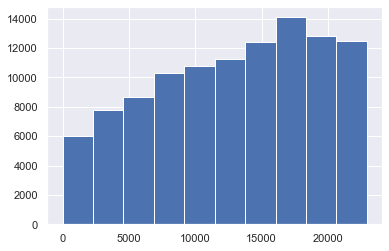

In [14]:
plt.hist(tracks[("album", "id")])

In [15]:
tracks[("artist", "name")]

track_id
2                     AWOL
3                     AWOL
5                     AWOL
10               Kurt Vile
20              Nicky Cook
                ...       
155316             Spowder
155317             Spowder
155318             Spowder
155319             Spowder
155320    Forget the Whale
Name: (artist, name), Length: 106574, dtype: object

In [16]:
tracks[("artist", "name")].unique()

array(['AWOL', 'Kurt Vile', 'Nicky Cook', ...,
       'Alex Mason/BlackSunAeon Music', 'AWOTT', 'Spowder'], dtype=object)

In [86]:
tracks[("artist", "name")].value_counts()

Kosta T                          745
Podington Bear                   604
Ergo Phizmiz                     499
Blue Dot Sessions                416
Lee Rosevere                     371
                                ... 
Jockers Dance Orchestra            1
Red Lamp Auckestra Vs. Daniel      1
Ayato & Extrasystole               1
Vapen                              1
Ascent                             1
Name: (artist, name), Length: 16294, dtype: int64

In [17]:
tracks[("album", "type")]

track_id
2                    Album
3                    Album
5                    Album
10                   Album
20                   Album
                ...       
155316    Live Performance
155317    Live Performance
155318    Live Performance
155319    Live Performance
155320               Album
Name: (album, type), Length: 106574, dtype: category
Categories (5, object): [Album, Contest, Live Performance, Radio Program, Single Tracks]

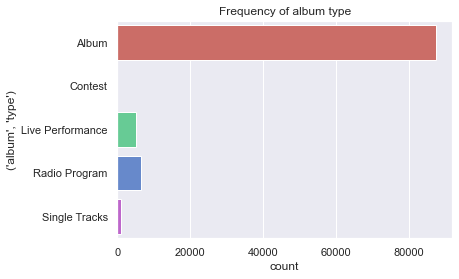

In [18]:
sns.countplot(y=("album", "type"), data=tracks, palette='hls')
plt.title('Frequency of album type')
plt.show()

In [80]:
tracks[("album", "type")].value_counts()

Album               87549
Radio Program        6551
Live Performance     5035
Single Tracks         917
Contest                14
Name: (album, type), dtype: int64

In [87]:
tracks[("album", "listens")].value_counts()

-1         3529
 325595     310
 97866      151
 70247      150
 30149      142
           ... 
 473          1
 601          1
 10844        1
 6810         1
 2049         1
Name: (album, listens), Length: 10092, dtype: int64

Text(0, 0.5, 'count')

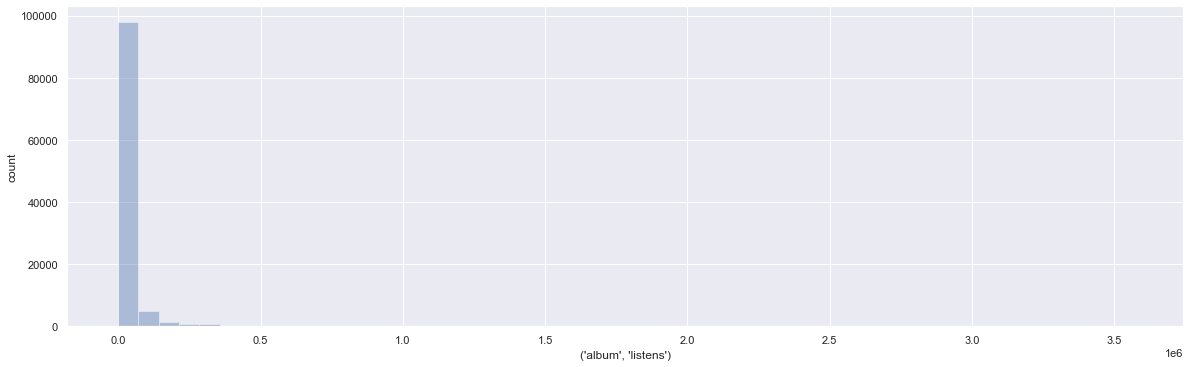

In [92]:
fig =plt.subplots(figsize=(20, 20))
ax = plt.subplot2grid(fig_dims, (0, 0))
sns.distplot(tracks[("album", "listens")].dropna(), kde=False)
plt.ylabel("count")


In [89]:
tracks[("track", "listens")].value_counts()

96       140
97       136
141      133
112      130
152      129
        ... 
8742       1
10791      1
23081      1
8806       1
0          1
Name: (track, listens), Length: 12035, dtype: int64

Text(0, 0.5, 'count')

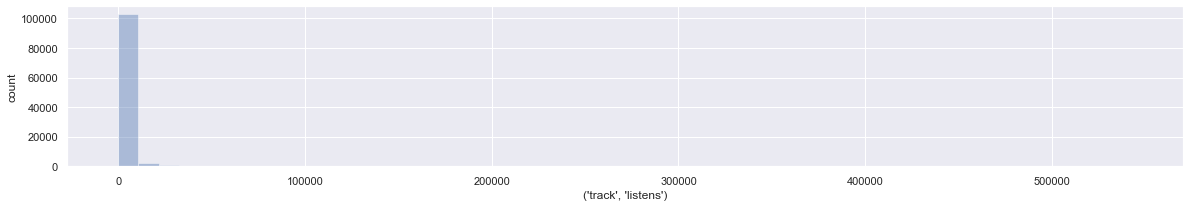

In [94]:
fig =plt.subplots(figsize=(20, 10))
ax = plt.subplot2grid(fig_dims, (0, 0))
sns.distplot(tracks[("track", "listens")].dropna(), kde=False)
plt.ylabel("count")


# Missing Value detection

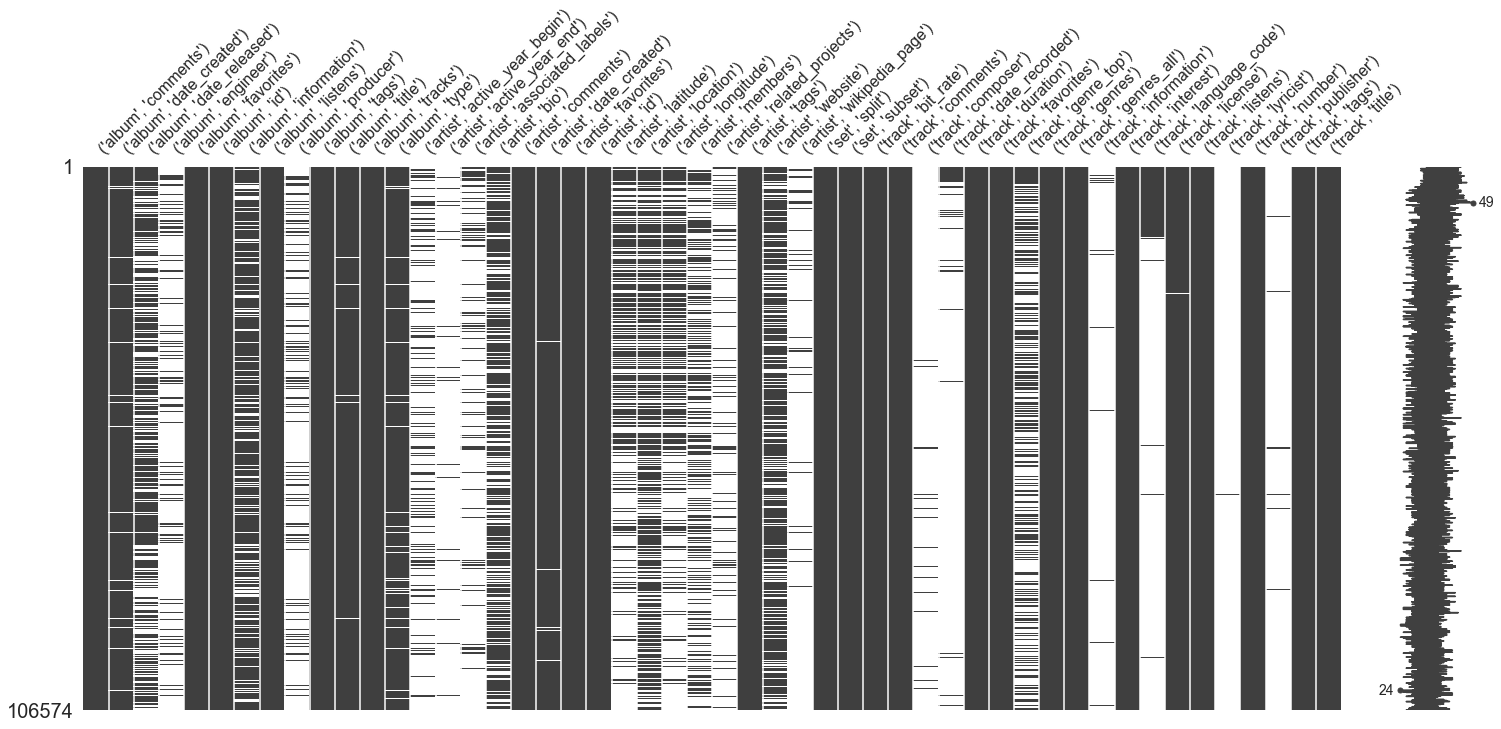

In [19]:
msno.matrix(top_data)

[]

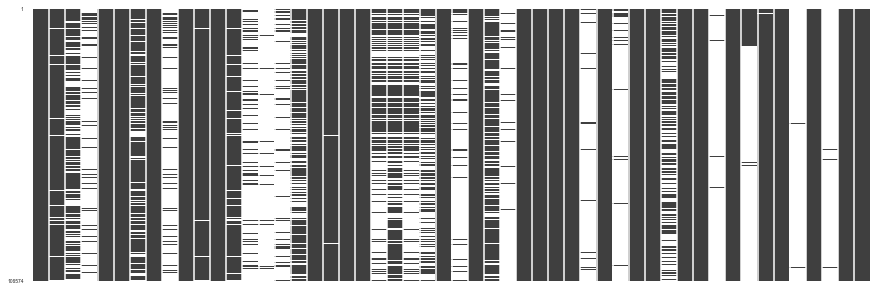

In [20]:
fig = plt.subplots(figsize=(15, 5))
fig_dims = (1, 1)

ax = plt.subplot2grid(fig_dims, (0, 0))
msno.matrix(tracks, ax=ax,sparkline=False)
plt.xticks(rotation=90, fontsize=5)
plt.yticks(fontsize=5)
plt.plot()

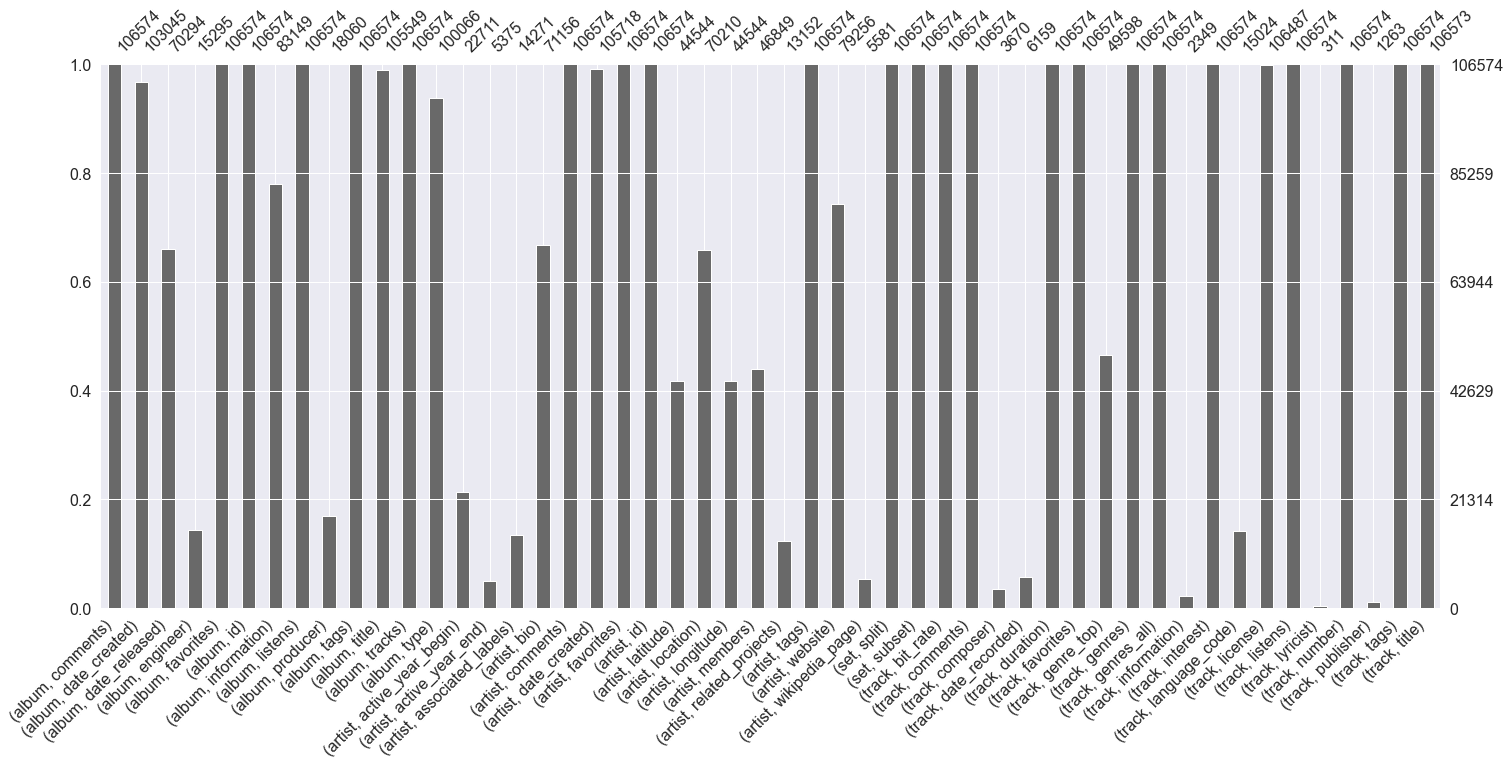

In [21]:
msno.bar(top_data)

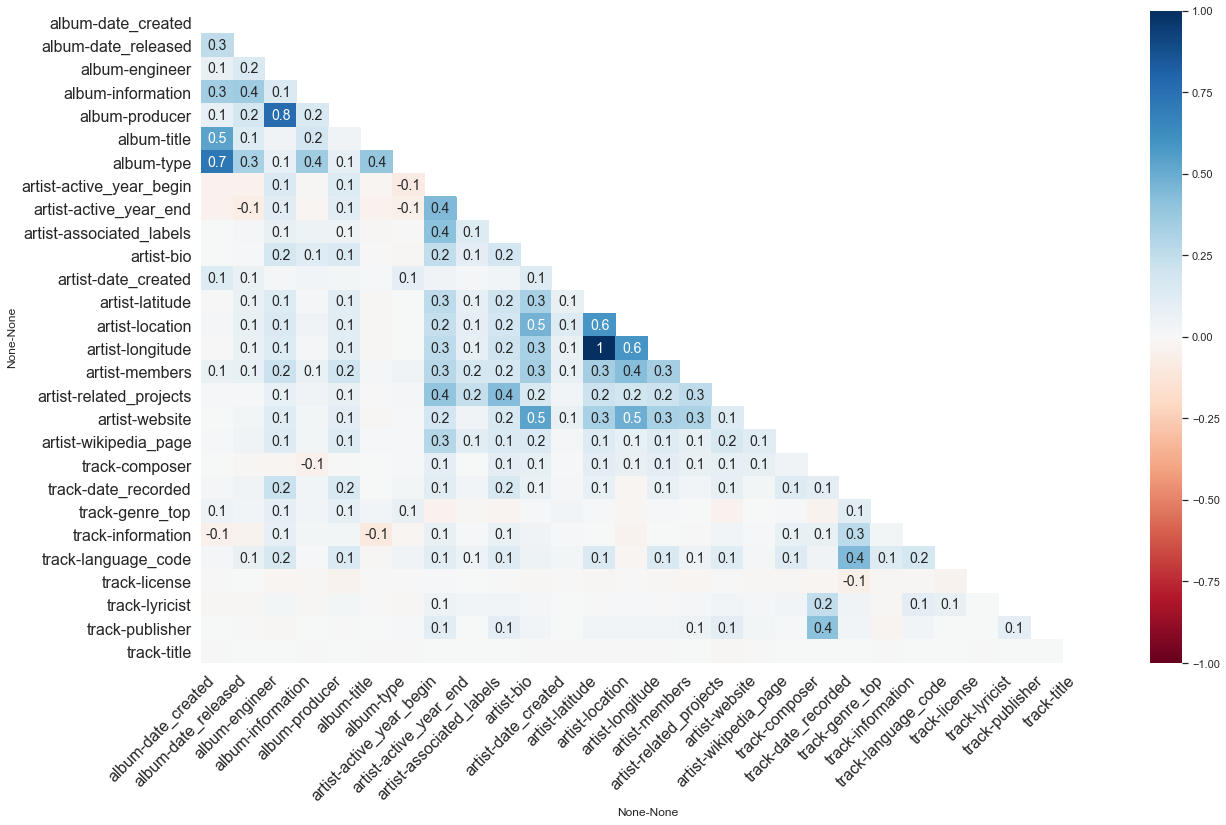

In [22]:
msno.heatmap(tracks)

In [24]:
# checking columns' missing data
column_names = list(tracks.columns)
for column_name in column_names:
    # count number of rows with missing values
    data = tracks[column_name]
    n_miss = data.isnull().sum()
    perc = n_miss / tracks.shape[0] * 100
    if n_miss > 0:
        print( '%s, Missing: %d (%.1f%% of rows) ' % (column_name, n_miss, perc))

('album', 'date_created'), Missing: 3529 (3.3% of rows) 
('album', 'date_released'), Missing: 36280 (34.0% of rows) 
('album', 'engineer'), Missing: 91279 (85.6% of rows) 
('album', 'information'), Missing: 23425 (22.0% of rows) 
('album', 'producer'), Missing: 88514 (83.1% of rows) 
('album', 'title'), Missing: 1025 (1.0% of rows) 
('album', 'type'), Missing: 6508 (6.1% of rows) 
('artist', 'active_year_begin'), Missing: 83863 (78.7% of rows) 
('artist', 'active_year_end'), Missing: 101199 (95.0% of rows) 
('artist', 'associated_labels'), Missing: 92303 (86.6% of rows) 
('artist', 'bio'), Missing: 35418 (33.2% of rows) 
('artist', 'date_created'), Missing: 856 (0.8% of rows) 
('artist', 'latitude'), Missing: 62030 (58.2% of rows) 
('artist', 'location'), Missing: 36364 (34.1% of rows) 
('artist', 'longitude'), Missing: 62030 (58.2% of rows) 
('artist', 'members'), Missing: 59725 (56.0% of rows) 
('artist', 'related_projects'), Missing: 93422 (87.7% of rows) 
('artist', 'website'), Mis

# Zero Value Detection

In [53]:
data_types = tracks.dtypes
for column_name, column_type in data_types.items():
    if column_type == np.int or column_type == np.float:
        zero_values = (tracks[column_name] == 0).sum()
        if zero_values > 0:
            print(column_name, zero_values, sep="\t")

Gli attributi numerici possono presentare missing value ma non ci sono in questo caso, ottimo

# Controllo se ci sono Rows duplicate

# Columns Unique Value Lookup

Elimino le colonne con valori strani tipo (album, tags) prima, senno mi da errore

In [54]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 52 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   (album, comments)            106574 non-null  int64         
 1   (album, date_created)        103045 non-null  datetime64[ns]
 2   (album, date_released)       70294 non-null   datetime64[ns]
 3   (album, engineer)            15295 non-null   object        
 4   (album, favorites)           106574 non-null  int64         
 5   (album, id)                  106574 non-null  int64         
 6   (album, information)         83149 non-null   category      
 7   (album, listens)             106574 non-null  int64         
 8   (album, producer)            18060 non-null   object        
 9   (album, tags)                106574 non-null  object        
 10  (album, title)               105549 non-null  object        
 11  (album, tracks)           

In [55]:
#del tracks["album", "tags"]
#del tracks["artist", "tags"]
#del tracks["track", "tags"]

In [56]:
column_names = tuple(tracks.columns)
for column_name in column_names: 
    unique_values = tracks[column_name].unique()
    if len(unique_values) >= 10:
        print(column_name, "more than 10 %s values" % tracks.dtypes[column_name], sep="\t")
    else:
         print(column_name, unique_values, sep="\t")

('album', 'comments')	more than 10 int64 values
('album', 'date_created')	more than 10 datetime64[ns] values
('album', 'date_released')	more than 10 datetime64[ns] values
('album', 'engineer')	more than 10 object values
('album', 'favorites')	more than 10 int64 values
('album', 'id')	more than 10 int64 values
('album', 'information')	more than 10 category values
('album', 'listens')	more than 10 int64 values
('album', 'producer')	more than 10 object values


TypeError: unhashable type: 'list'

# Correlation

In [57]:
def draw_sns_heatmap(correlation_matrix, h_neg, h_pos, title, pngfile):
    """
    Function which draws a seaborn' heatmap based on the correlation matrix passed by argument
    """
    # generate a mask for the upper triangle
    mask = np.zeros_like(correlation_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(40, 10))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(h_neg, h_pos, as_cmap=True)
    
    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title)
    plt.xticks(fontsize=10)



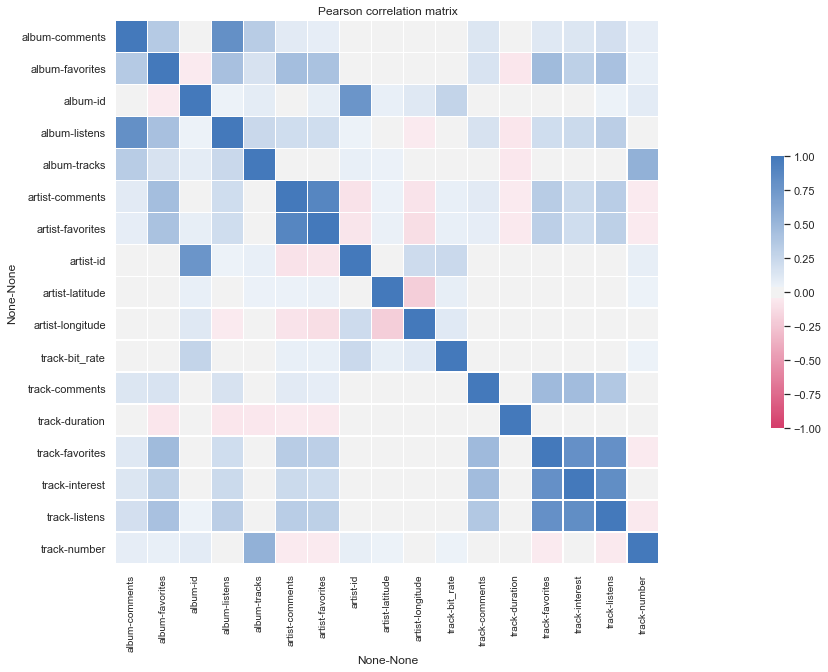

In [58]:
# compute the correlation matrix, excluding NA/null values
correlation_matrix = tracks.corr("pearson")  # pearson correlation
# draw heatmap
draw_sns_heatmap(correlation_matrix, 0, 250, "Pearson correlation matrix", "pearson_correlation_matrix.png")

# First Look Distribution

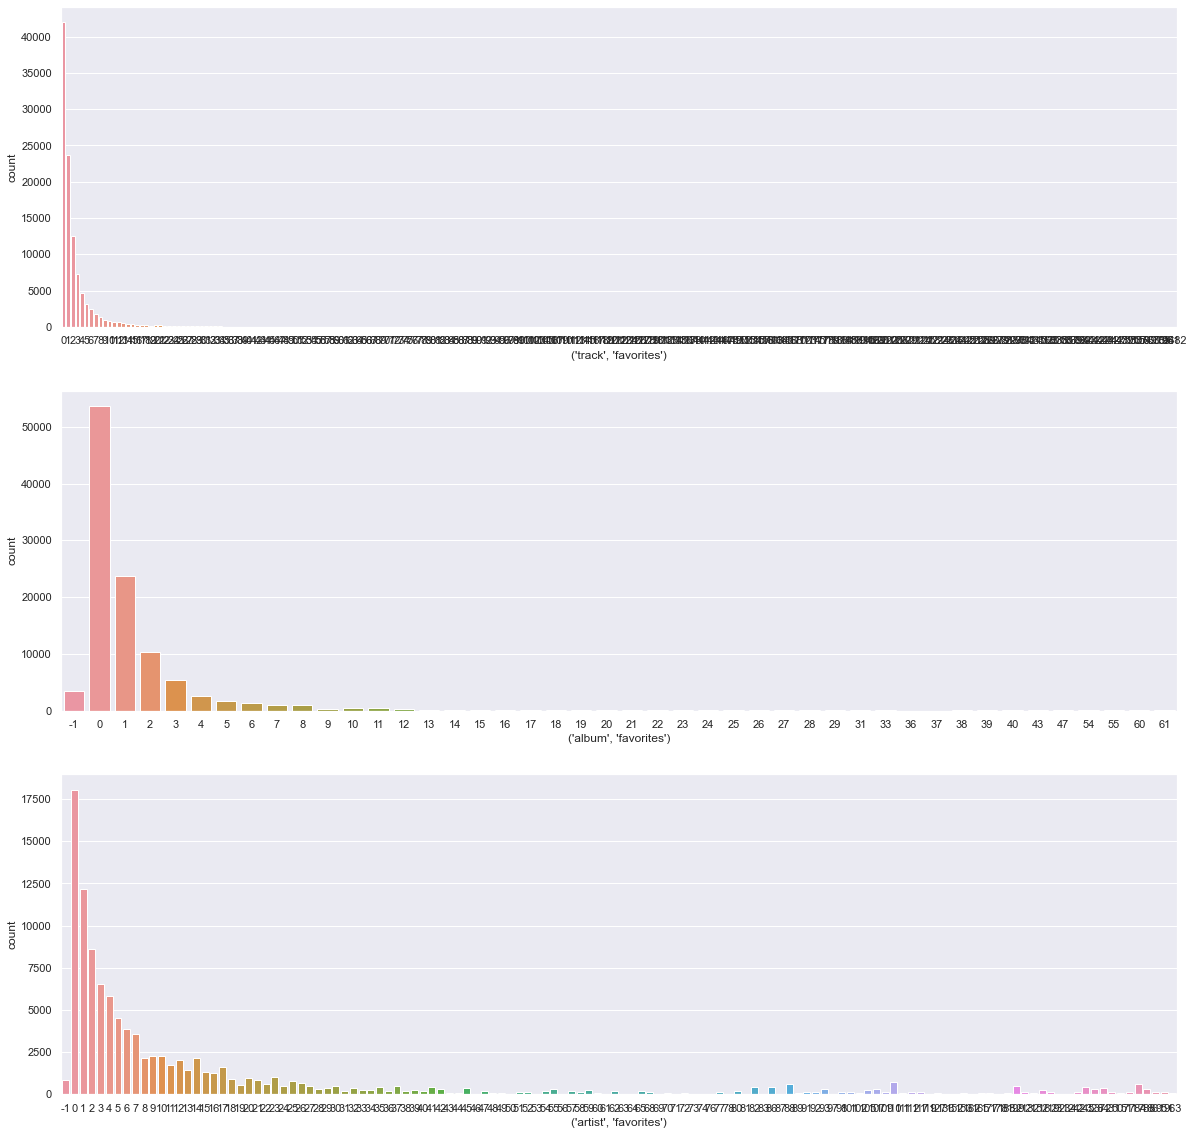

In [75]:
fig = plt.subplots(figsize=(20, 20))
fig_dims =(3,1)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.countplot(x=('track','favorites'), data=tracks)

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.countplot(x=('album','favorites'), data=tracks)

ax = plt.subplot2grid(fig_dims, (2, 0))
sns.countplot(x=('artist','favorites'), data=tracks)